# PROPOSED CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=2)

mean = 0.
std = 0.
nb_samples = 0.

for data in loader:
    images, _ = data
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')


Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2023, 0.1994, 0.2010])


In [3]:

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model = EnhancedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/10] - Loss: 1.7091, Train Acc: 36.28%
Test Accuracy: 49.23%, Test Loss: 1.3814

Epoch [2/10] - Loss: 1.3014, Train Acc: 53.04%
Test Accuracy: 60.64%, Test Loss: 1.0685

Epoch [3/10] - Loss: 1.1162, Train Acc: 60.97%
Test Accuracy: 68.96%, Test Loss: 0.8973

Epoch [4/10] - Loss: 0.9945, Train Acc: 65.45%
Test Accuracy: 71.70%, Test Loss: 0.8087

Epoch [5/10] - Loss: 0.8942, Train Acc: 69.56%
Test Accuracy: 75.14%, Test Loss: 0.7186

Epoch [6/10] - Loss: 0.8251, Train Acc: 72.35%
Test Accuracy: 76.22%, Test Loss: 0.7021

Epoch [7/10] - Loss: 0.7596, Train Acc: 74.56%
Test Accuracy: 78.27%, Test Loss: 0.6398

Epoch [8/10] - Loss: 0.7068, Train Acc: 76.46%
Test Accuracy: 80.37%, Test Loss: 0.5856

Epoch [9/10] - Loss: 0.6614, Train Acc: 78.10%
Test Accuracy: 81.63%, Test Loss: 0.5533

Epoch [10/10] - Loss: 0.6213, Train Acc: 79.47%
Test Accuracy: 83.42%, Test Loss: 0.5011



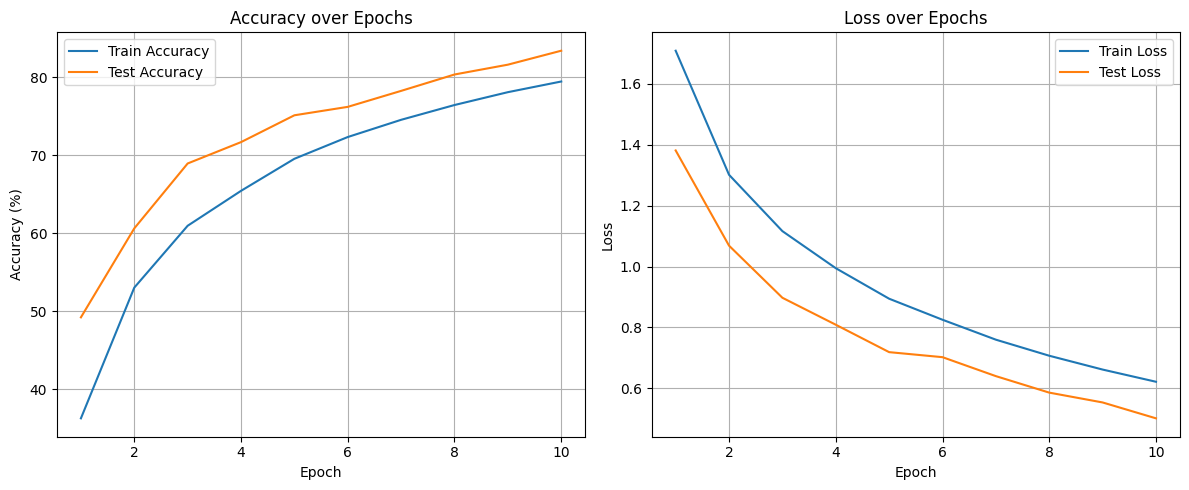

In [5]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def evaluate():
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    acc = 100. * correct / total
    test_losses.append(avg_loss)
    test_accuracies.append(acc)
    print(f"Test Accuracy: {acc:.2f}%, Test Loss: {avg_loss:.4f}\n")

def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        avg_loss = running_loss / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")
        evaluate()

train(num_epochs=10)

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# BASELINE CNN

In [19]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
learning_rate = 0.001
num_epochs = 10


In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [22]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
model = BaselineCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/10] - Train Loss: 1.2172, Train Acc: 56.55%, Test Loss: 1.0025, Test Acc: 64.47%
Epoch [2/10] - Train Loss: 0.8288, Train Acc: 70.75%, Test Loss: 0.8993, Test Acc: 68.92%
Epoch [3/10] - Train Loss: 0.6294, Train Acc: 77.94%, Test Loss: 0.8099, Test Acc: 72.62%
Epoch [4/10] - Train Loss: 0.4507, Train Acc: 84.32%, Test Loss: 0.8380, Test Acc: 73.38%
Epoch [5/10] - Train Loss: 0.3018, Train Acc: 89.53%, Test Loss: 0.9938, Test Acc: 73.10%
Epoch [6/10] - Train Loss: 0.1951, Train Acc: 93.28%, Test Loss: 1.1513, Test Acc: 71.86%
Epoch [7/10] - Train Loss: 0.1346, Train Acc: 95.31%, Test Loss: 1.3594, Test Acc: 71.88%
Epoch [8/10] - Train Loss: 0.1092, Train Acc: 96.29%, Test Loss: 1.5456, Test Acc: 71.52%
Epoch [9/10] - Train Loss: 0.0941, Train Acc: 96.82%, Test Loss: 1.6389, Test Acc: 71.69%
Epoch [10/10] - Train Loss: 0.0880, Train Acc: 97.03%, Test Loss: 1.7229, Test Acc: 72.37%


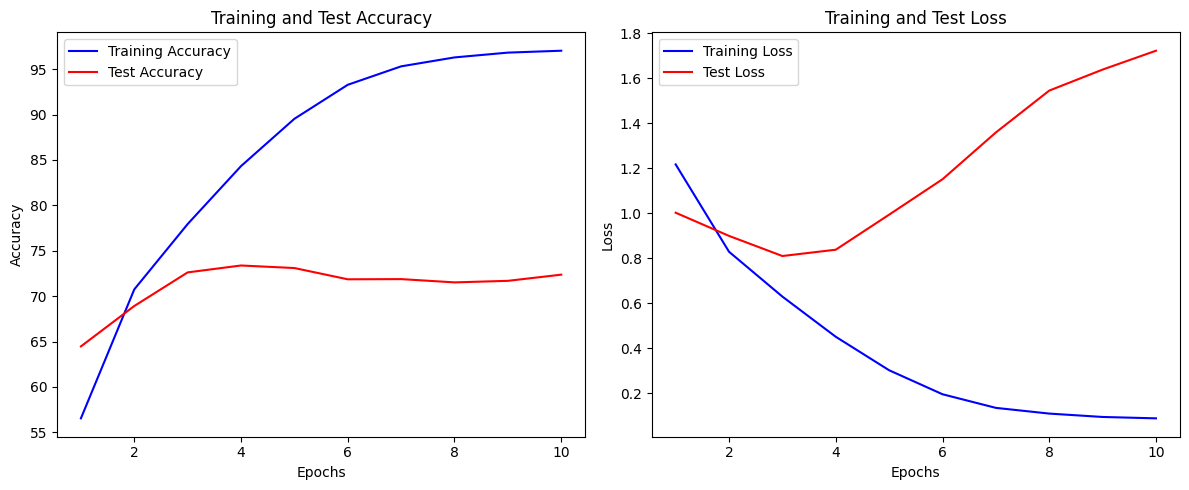

In [24]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if (i + 1) % 100 == 0:
        #     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    model.eval()
    correct = 0
    total = 0
    epoch_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_test_loss = epoch_test_loss / len(test_loader)
    epoch_test_acc = 100 * correct / total
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, test_acc, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# PROPOSED VS. BASELINE

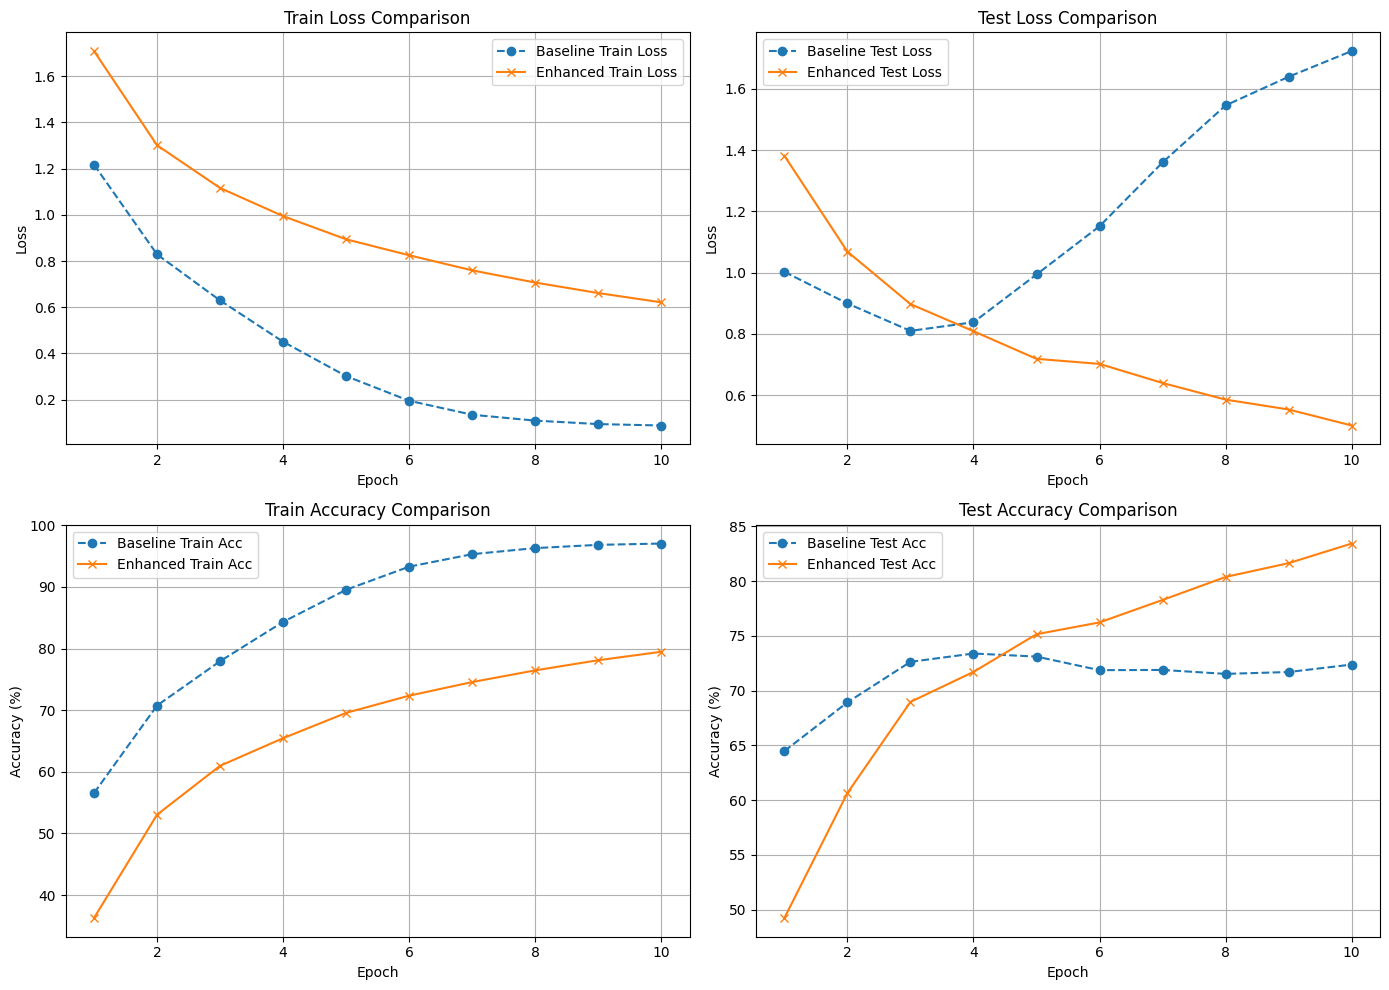

In [25]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label='Baseline Train Loss', linestyle='--', marker='o')
plt.plot(epochs, train_losses, label='Enhanced Train Loss', linestyle='-', marker='x')
plt.title('Train Loss Comparison')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, test_loss, label='Baseline Test Loss', linestyle='--', marker='o')
plt.plot(epochs, test_losses, label='Enhanced Test Loss', linestyle='-', marker='x')
plt.title('Test Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, train_acc, label='Baseline Train Acc', linestyle='--', marker='o')
plt.plot(epochs, train_accuracies, label='Enhanced Train Acc', linestyle='-', marker='x')

plt.title('Train Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, test_acc, label='Baseline Test Acc', linestyle='--', marker='o')
plt.plot(epochs, test_accuracies, label='Enhanced Test Acc', linestyle='-', marker='x')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()